A vs swap slippage

In [1]:
import sys, os
sys.path.append("../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network

import brownie
from brownie.network import chain

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)
brownie.network.connect('mainnet-fork')


Launching 'ganache-cli --port 8545 --gasLimit 12000000 --accounts 10 --hardfork istanbul --mnemonic brownie --fork https://eth-mainnet.alchemyapi.io/v2/AxU0de70ONfvbD-3_pQX0wUlaBK6g3G4 --chainId 1'...


In [4]:
pool_contract_addr = "0x9D0464996170c6B9e75eED71c68B99dDEDf279e8"  # cvxcrv pool addr

pool_contract = init_contract(contract_addr=pool_contract_addr)
pool_info = pool_contract.info()

initial_A = pool_contract.initial_A()
initial_A_time = pool_contract.initial_A_time()
A = pool_contract.A()
A_precise = pool_contract.A_precise()
A_precision = int(A_precise/A)

print(f"pool param details:")
print(f"initial_A: {initial_A}")
print(f"initial_A_time: {initial_A_time}")
print(f"A: {A}")
print(f"A_precise: {A_precise}")
print(f"A_precision: {A_precision}")

  @title StableSwap
  @notice 2 coin pool implementation with no lending
  @author Curve.Fi
  @details Optimized to only support ERC20's with 18
           decimals that return True/revert

pool param details:
initial_A: 5000
initial_A_time: 0
A: 50
A_precise: 5000
A_precision: 100


In [5]:
coin_0 = init_contract(pool_contract.coins(0)).name()
coin_1 = init_contract(pool_contract.coins(1)).name()

pool_balances = pool_contract.get_balances()
total_coins = (pool_balances[1]+pool_balances[0])

coin_perc_string = f"Pool ratios: {coin_0}: {round(pool_balances[0]/total_coins * 100, 2)}%, {coin_1}: {round(pool_balances[1]/total_coins * 100, 2)}%"

coin_perc_string

'Pool ratios: Curve DAO Token: 37.08%, Convex CRV: 62.92%'

# Swap rates as a function of A

In [6]:
sender = brownie.accounts.at(init_contract("0xb9fc157394af804a3578134a6585c0dc9cc990d4").admin(), force=True)

In [7]:
dx = 10000 * 1e18

In [8]:
future_A = int(500)
A_ramp_steps = int(10)
A_params_simulation = list(range(A, future_A+A_ramp_steps, A_ramp_steps))

coin A to B

make snapshot of chain first:

In [9]:
chain.snapshot()
t0 = chain.time()
t1 = int(t0 + 7 * 86400)

In [10]:
swap_rates_A_to_B = []
for amplification_factor in A_params_simulation:

    pool_contract.ramp_A(amplification_factor, t1, {"from": sender})

    chain.sleep(t1)
    chain.mine()

    dy = pool_contract.get_dy(0, 1, dx)

    swap_rates_A_to_B.append(dy)

    chain.revert()

swap_rates_A_to_B

Transaction sent: 0x26b5cc62fe67a8622a472f4399d7a43a5f3ce4f7c99eb9e8aa27c074af374723
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 900
  Vyper_contract.ramp_A confirmed   Block: 13270828   Gas used: 72974 (0.61%)

Transaction sent: 0x94887bfa322a13ebf76889e84499db9b6d6818b17fa46398ae169899f9760830
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 900
  Vyper_contract.ramp_A confirmed   Block: 13270828   Gas used: 77174 (0.64%)

Transaction sent: 0xda56da9a371619ec67de0c35455c3380c881ee13cc4ba5178e6b74f1e2e09019
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 900
  Vyper_contract.ramp_A confirmed   Block: 13270828   Gas used: 77174 (0.64%)

Transaction sent: 0x11cfc4f6fd9f81bcc56493651982fca0aa0ad2db4ae569306b356d81950ef3cd
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 900
  Vyper_contract.ramp_A confirmed   Block: 13270828   Gas used: 77174 (0.64%)

Transaction sent: 0x33f323399dc7739b014f9cd566f3dfcc935b5bd9084407f327d250add0ac67f5
  Gas price: 0.0 gwei   Gas lim

[10101147488225433060420,
 10082092864432003627980,
 10068409260855919662621,
 10058106233733718603058,
 10050068732023823206639,
 10043623519201598733704,
 10038340069764961959796,
 10033930235508327081227,
 10030193883361883890911,
 10026987673976959396820,
 10024206250081629953199,
 10021770437436450080571,
 10019619586934366254667,
 10017706455879466630008,
 10015993697627397645359,
 10014451399332061084116,
 10013055320009593620019,
 10011785607053661802778,
 10010625846188211394144,
 10009562347990388732189,
 10008583604996019743062,
 10007679873629652990356,
 10006842848711329666666,
 10006065407474598775208,
 10005341406372302662818,
 10004665518392097910053,
 10004033101762467691427,
 10003440093203006132788,
 10002882920527652844926,
 10002358430627619597251,
 10001863829766451096164,
 10001396633799536190813,
 10000954626445311345947,
 10000535824128673638489,
 10000138446219861958170,
 9999760889726852084564,
 9999401707682679584577,
 9999059590613268783995,
 99987333505854

coin B to A

In [11]:
swap_rates_B_to_A = []
for amplification_factor in A_params_simulation:

    pool_contract.ramp_A(amplification_factor, t1, {"from": sender})

    chain.sleep(t1)
    chain.mine()

    swap_rates_B_to_A.append(pool_contract.get_dy(1, 0, dx))

    chain.revert()

swap_rates_B_to_A

Transaction sent: 0x26b5cc62fe67a8622a472f4399d7a43a5f3ce4f7c99eb9e8aa27c074af374723
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 900
  Vyper_contract.ramp_A confirmed   Block: 13270828   Gas used: 72974 (0.61%)

Transaction sent: 0x94887bfa322a13ebf76889e84499db9b6d6818b17fa46398ae169899f9760830
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 900
  Vyper_contract.ramp_A confirmed   Block: 13270828   Gas used: 77174 (0.64%)

Transaction sent: 0xda56da9a371619ec67de0c35455c3380c881ee13cc4ba5178e6b74f1e2e09019
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 900
  Vyper_contract.ramp_A confirmed   Block: 13270828   Gas used: 77174 (0.64%)

Transaction sent: 0x11cfc4f6fd9f81bcc56493651982fca0aa0ad2db4ae569306b356d81950ef3cd
  Gas price: 0.0 gwei   Gas limit: 12000000   Nonce: 900
  Vyper_contract.ramp_A confirmed   Block: 13270828   Gas used: 77174 (0.64%)

Transaction sent: 0x33f323399dc7739b014f9cd566f3dfcc935b5bd9084407f327d250add0ac67f5
  Gas price: 0.0 gwei   Gas lim

[9869864906677226396641,
 9888570849087497049383,
 9902047900319405252785,
 9912219696298666505130,
 9920169359328824197065,
 9926553362393683050505,
 9931792773152920882137,
 9936170091309528448252,
 9939881917030767980819,
 9943069293831944970928,
 9945836038228473534865,
 9948260261627628163969,
 9950401862373263610601,
 9952307541746193745049,
 9954014248774327683553,
 9955551599544137168638,
 9956943610343659414659,
 9958209961436779946907,
 9959366933364275187871,
 9960428110671897979031,
 9961404917784719923565,
 9962307031951306186343,
 9963142704946566797573,
 9963919016218010505114,
 9964642073935540323431,
 9965317176038123133464,
 9965948940265335111319,
 9966541409925618616647,
 9967098140523932277123,
 9967622271171611416484,
 9968116583808567349320,
 9968583552597480557640,
 9969025385341576801827,
 9969444058389351625432,
 9969841346190620350602,
 9970218846436294860967,
 9970578001533042285206,
 9970920117021430078096,
 9971246377433340315206,
 9971557859994610427464,


add decimals

In [16]:
perc_A_to_B = [round((i-dx) / dx * 100, 4) for i in swap_rates_A_to_B]
perc_B_to_A = [round((i-dx) / dx * 100, 4) for i in swap_rates_B_to_A]

In [13]:
current_block = brownie.web3.eth.block_number

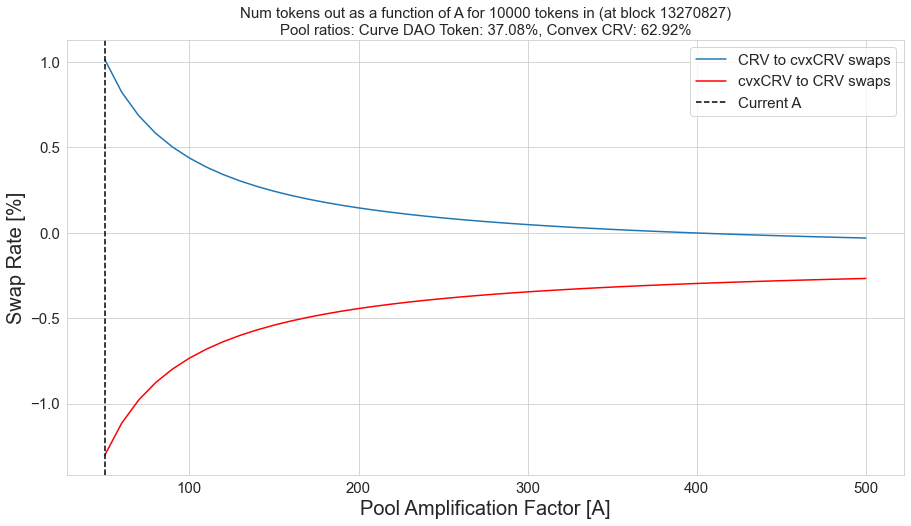

In [21]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))

ax.plot(A_params_simulation, perc_A_to_B, label="CRV to cvxCRV swaps")
ax.plot(A_params_simulation, perc_B_to_A, 'r', label="cvxCRV to CRV swaps")

ax.axvline(x=A, label="Current A", color='k', ls='--')

ax.set_xlabel("Pool Amplification Factor [A]", fontsize=20)
ax.set_ylabel("Swap Rate [%]", fontsize=20)
ax.set_title(f"Num tokens out as a function of A for {int(dx*1e-18)} tokens in (at block {current_block})\n{coin_perc_string}", fontsize=15);
ax.tick_params(axis='both', which='major', labelsize=15);

ax.legend(fontsize=15);

disconnect.

In [15]:
brownie.network.disconnect()

Terminating local RPC client...
